In [1]:
import scipy.stats
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import xarray as xr
import tqdm
import os
import pickle
from tqdm.notebook import tqdm

## set plotting style
sns.set()

# ## initialize random number generator
# rng = np.random.default_rng()

path = "/glade/work/alancelin/EVT_rossbypalooza/"
os.chdir(path)

from src.evt import *

In [3]:
from pydrive.auth import GoogleAuth, ServiceAccountCredentials
from pydrive.drive import GoogleDrive

# Step 1: Load client secrets
gauth = GoogleAuth()
gauth.LoadClientConfigFile('/glade/work/alancelin/EVT_rossbypalooza/scripts/coldspells/client_secret.json')  # Use your downloaded JSON file

# Step 2: Handle manual authentication
gauth.CommandLineAuth()  # Opens a URL in the terminal for manual authentication

# Step 3: Create GoogleDrive instance
drive = GoogleDrive(gauth)
drive

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=673680778613-r3bb6gp4og90odjgmbdtndinntc224nq.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


## Training and validation data

In [4]:
# Step 4: Define the folder ID
folder_id = '1zXUQmBBQWTJ796bgdi_ZgbV3Lnwfn2tk'

# Step 5: List the files in the specified folder
folder_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()
# for file in folder_list:
#     print(f'title: {file["title"]}, id: {file["id"]}')

# for each folder 'sim0', print the files
for file in folder_list:
    if file['title'] == 'sim0':
        sim0_id = file['id']
        sim0_file_list = drive.ListFile({'q': f"'{sim0_id}' in parents and trashed=false"}).GetList()
        # for sim0_file in sim0_file_list:
        #     print(f'title: {sim0_file["title"]}, id: {sim0_file["id"]}')

# in that folder 'sim0', read the file 'tas_lat.46_lon.6_spatial.2_reduce.min.csv' using pandas
for file in sim0_file_list:
    if file['title'] == 'tas_lat.46_lon.6_spatial.2_reduce.min.csv':
        file.GetContentFile('tas_lat.46_lon.6_spatial.2_reduce.min.csv')
        df_train_val = pd.read_csv('tas_lat.46_lon.6_spatial.2_reduce.min.csv', index_col=0)

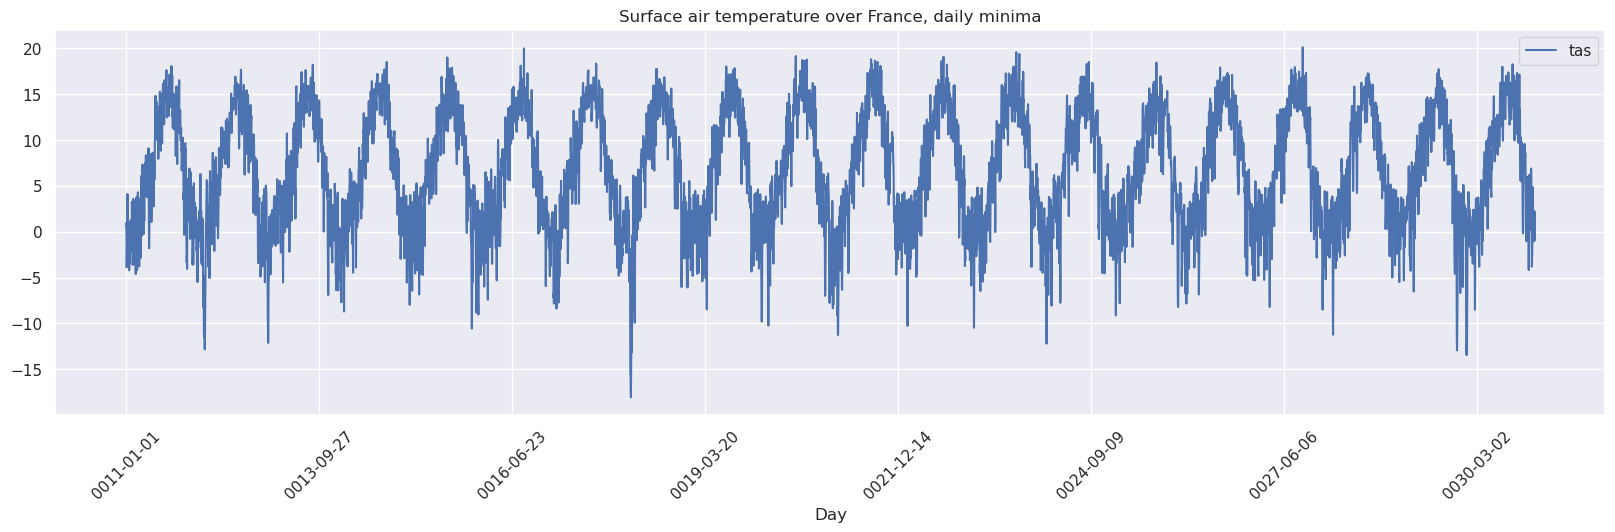

In [5]:
fig, ax = plt.subplots(figsize=(20, 5))
# print time series of df for the first 10 years
(df_train_val - 273.15).iloc[:20*365].plot(ax=ax)
# change orientation of x-axis labels
plt.xticks(rotation=45)
# add title
plt.title('Surface air temperature over France, daily minima')
plt.show()

In [6]:
def preprocess(df, T=7):
    # convert the index to pandas.period
    df.index = pd.PeriodIndex(df.index, freq='D')
    # convert the temperature to celsius
    df = df - 273.15
    # compute the T-day rolling mean
    df = df.rolling(T).mean()
    # take the minimum of each year (Block Maxima approach)
    df = df.groupby(df.index.year).min()
    # change day to year
    df.index.name = 'Year'
    return df

In [7]:
T=7
A_train_val = preprocess(df_train_val, T=T)

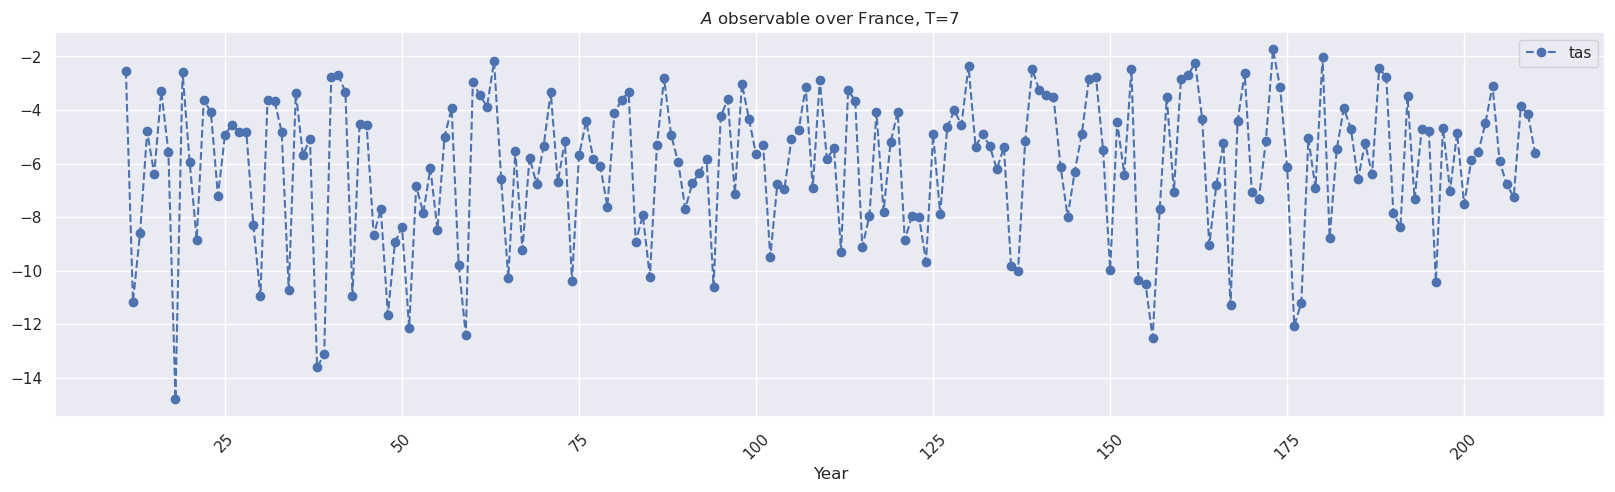

In [8]:
fig, ax = plt.subplots(figsize=(20, 5))
# print time series of df for the first 10 years (scatter plot)
(A_train_val).iloc[:200].plot(ax=ax, marker='o', linestyle='--')
# change orientation of x-axis labels
plt.xticks(rotation=45)
# add title
plt.title(r'$A$'+ f' observable over France, T={T}')
plt.show()

## Load test data (long ground truth)

In [ ]:
# for every folder in folder_list, read the file 'tas_lat.46_lon.6_spatial.2_reduce.min.csv' using pandas and finally concatenate all the dataframes
dfs = []


def produce_A_ground_truth(folder_list, T=7):
    for file in tqdm(folder_list):
        sim0_id = file['id']
        if file['title'] == 'sim0':
            # skip the folder 'sim0'
            continue
        sim0_file_list = drive.ListFile({'q': f"'{sim0_id}' in parents and trashed=false"}).GetList()
        for sim0_file in sim0_file_list:
            if sim0_file['title'] == 'tas_lat.46_lon.6_spatial.2_reduce.min.csv':
                sim0_file.GetContentFile('tas_lat.46_lon.6_spatial.2_reduce.min.csv')
                dfs.append(preprocess(pd.read_csv('tas_lat.46_lon.6_spatial.2_reduce.min.csv', index_col=0), T=T))
    return pd.concat(dfs, axis=0, ignore_index=True)

A_test = produce_A_ground_truth(folder_list, T=T)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
A_test.to_csv(f'A_test_T{T}.csv')

In [10]:
A_test = pd.read_csv(f'/glade/work/alancelin/EVT_rossbypalooza/scripts/coldspells/A_test_T7.csv', index_col=0)

## Functions

In [ ]:
# def load_data():
#     """Load raw data from CSV file"""

#     # Load from CSV
#     data = pd.read_csv("../data/train/A_tas_lat.41_lon.272_spatial.2_reduce.max.csv")

#     # set time data as index
#     data = data.set_index("time")

#     # convert to xarray
#     data = xr.Dataset.from_dataframe(data)["tas"]

#     # update time axis (string to cftime object)
#     updated_time = xr.cftime_range(
#         start=data["time"].values[0], periods=len(data["time"]), freq="1D"
#     )
#     data["time"] = updated_time

#     return data


# def load_prepped_data(model_type, thresh=None):
#     """
#     Load prepped data. Pre-processing depends on model type:
#         - if model_type=='gev' block the data
#         - if model_type=='gp', get peaks over threshold
#     """

#     ## load raw data
#     data = load_data()

#     if model_type == "gev":
#         data_prepped = data.groupby("time.year").max().values

#     elif model_type == "gp":
#         data_prepped = data.isel(time=data > thresh).values

#     else:
#         print("Error: input valid model class")
#         return

#     return data_prepped


# def get_train_test_split(data_prepped, n_train):
#     """
#     Split data into training and testing sets
#     """

#     ## split data
#     train, test = data_prepped[:n_train], data_prepped[n_train:]

#     return train, test

In [ ]:
## specify model type, one of {"gev", "gp"}
model_type = "gev"

if model_type == "gev":
    model_class = scipy.stats.genextreme
    thresh = None

elif model_type == "gp":
    model_class = scipy.stats.genpareto
    thresh = 318

## Load data
X = load_prepped_data(model_type=model_type, thresh=thresh)

## Empirical PDF (normalized histogram)
pdf_empirical, bin_edges = get_empirical_pdf(X)

## Empirical return period
tr_empirical, Xr_empirical = get_empirical_return_period(X)

## Fit model and get return levels
model = fit_model(X, model_class)
Xr, tr = get_return_levels(model)

## Compute confidence interval
bounds_fp = f"../data/{model_type}_bounds.pkl"
Xr_lb, Xr_ub = load_return_period_bnds(
    X, model_class=model_class, n_samples=1000, save_fp=bounds_fp
)

## Plot PDF

In [11]:
def split_train_val(data_train_val, n_train):
    """
    Split data into training and validation sets
    """
    ## split data
    data_train, data_val = data_train_val[:n_train], data_train_val[n_train:]
    return data_train, data_val

A_train, A_val = split_train_val(A_train_val, n_train=80)

X = - A_train.values.squeeze()
X_val = - A_val.values.squeeze()
X_test = - A_test.values.squeeze()

In [12]:
import importlib
import src.evt
importlib.reload(src.evt)
from src.evt import *

In [21]:
## specify model type, one of {"gev", "gp"}
model_type = "gev"

if model_type == "gev":
    model_class = scipy.stats.genextreme
    thresh = None

elif model_type == "gp":
    model_class = scipy.stats.genpareto
    thresh = 318

## Load data
# X = load_prepped_data(model_type=model_type, thresh=thresh)

## Empirical PDF (normalized histogram)
pdf_empirical, bin_edges = get_empirical_pdf(X)

## Empirical return period
tr_empirical, Xr_empirical = get_empirical_return_period(X)

## Fit model and get return levels
bounds = dict(c=[-5, 5], loc=[-5, 15], scale=[0, 10])
model = fit_model(X, model_class, bounds)
Xr, tr = get_return_levels(model)

## Compute confidence interval
import datetime
# format_date = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
bounds_fp = f"scripts/coldspells/bounds/{model_type}_T{T}_{format_date}_bounds.pkl"
Xr_lb, Xr_ub = load_return_period_bnds(
    X, model_class=model_class, n_samples=1000, save_fp=bounds_fp, bounds=bounds
)
Xr_lb, Xr_ub

Number of bins not specified. Using square root rule. 8


  3%|▎         | 34/1000 [00:04<01:55,  8.33it/s]/glade/u/apps/opt/conda/envs/npl/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:3071: RuntimeWarning: overflow encountered in exp
  pex2 = np.exp(logpex2)
100%|██████████| 1000/1000 [02:09<00:00,  7.69it/s]


(array([-1812.39805057,   164.17097221,   196.56473728,   200.74427808,
          201.59879499,   201.81697412,   201.88055671,   201.90078046,
          201.90762264,   201.91004518,   201.91093303,   201.91126726,
          201.91139577,   201.91144603,   201.91146596,   201.91147395,
          201.91147718,   201.9114785 ,   201.91147904,   201.91147926,
          201.91147935,   201.91147939,   201.91147941,   201.91147941,
          201.91147942,   201.91147942,   201.91147942,   201.91147942,
          201.91147942,   201.91147942,   201.91147942,   201.91147942,
          201.91147942,   201.91147942,   201.91147942,   201.91147942,
          201.91147942,   201.91147942,   201.91147942,   201.91147942,
          201.91147942,   201.91147942,   201.91147942,   201.91147942,
          201.91147942,   201.91147942,   201.91147942,   201.91147942,
          201.91147942,   201.91147942]),
 array([-1789.14560307,   164.3201325 ,   196.56875608,   200.7446065 ,
          201.60080873

In [18]:
model.args

(-0.10150172220958337, 5.01010718032151, 2.1849668188745905)

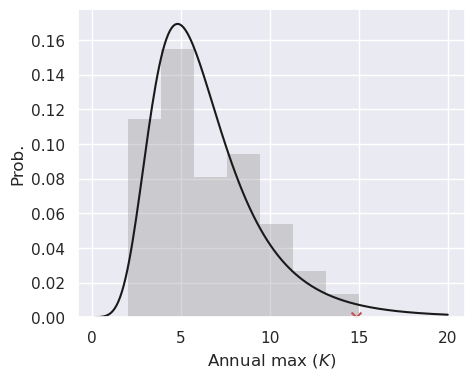

In [15]:
## test points to plot curve
X_plot = np.linspace(X.min()-2, 20, 200)

## setup plot
fig, ax = plt.subplots(figsize=(5, 4))

## plot empirical pdf
ax.stairs(pdf_empirical, edges=bin_edges, color="gray", fill=True, alpha=0.3)

# plot distribution fit
ax.plot(X_plot, model.pdf(X_plot), c="k")

## plot max value
ax.scatter(X.max(), 0, marker="x", c="r", s=50)

## label
ax.set_xlabel(r"Annual max ($K$)")
ax.set_ylabel("Prob.")

plt.show()

In [23]:
X

array([ 2.53668714, 11.16191286,  8.60425143,  4.79659714,  6.39649857,
        3.29071286,  5.56207714, 14.81498143,  2.58408571,  5.92732429,
        8.84284429,  3.62113714,  4.07260714,  7.20086143,  4.91695143,
        4.54430143,  4.81254857,  4.80559857,  8.29600429, 10.96382714,
        3.62697571,  3.67620429,  4.81958714, 10.72812714,  3.36290286,
        5.68508857,  5.08918714, 13.61376857, 13.13132143,  2.76974714,
        2.70543429,  3.32627714, 10.93663143,  4.51844714,  4.56133857,
        8.68186286,  7.69648   , 11.64457143,  8.92776714,  8.38725143,
       12.13814857,  6.8516    ,  7.84790571,  6.17187571,  8.47543571,
        5.00207857,  3.93852714,  9.80599571, 12.40318286,  2.96489714,
        3.44847571,  3.87907   ,  2.18321286,  6.59431   , 10.27782   ,
        5.51460429,  9.22821857,  5.77597143,  6.76193714,  5.33629143,
        3.33006857,  6.69397857,  5.15458571, 10.38421571,  5.68117714,
        4.41776429,  5.81759571,  6.10817   ,  7.61035429,  4.10

## Plot return level

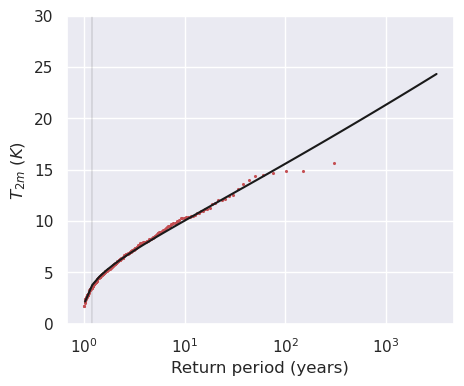

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))

## plot modeled return period
ax.plot(tr, Xr, c="k")
ax.fill_between(tr, Xr_ub, Xr_lb, color="k", alpha=0.1)

## plot empirical return period
ax.scatter(tr_empirical, Xr_empirical, c="r", s=1.5)

## label axes
ax.set_xlabel("Return period (years)")
ax.set_ylabel(r"$T_{2m}$ ($K$)")
ax.set_xscale("log")
ax.set_ylim(0, 30)

plt.show()

In [ ]:
model.args

(-0.023235097560347074, 4.997921650249097, 2.178907120672863)

### Compare with what we get from pyextremes

In [ ]:
series = pd.DataFrame(X)
# set the index of the series to be a datetime object
series['date'] = pd.date_range(start='1/1/1800', periods=len(series), freq='Y')
series.set_index('date', inplace=True)
series = series.rename(columns={0: 'T2m'})
series = series['T2m']
# from pandas import Timestamp
# series.index = Timestamp.to_pydatetime(series.index)

from pyextremes import EVA
model = EVA(series)

(<Figure size 768x480 with 1 Axes>, <Axes: xlabel='date', ylabel='T2m'>)

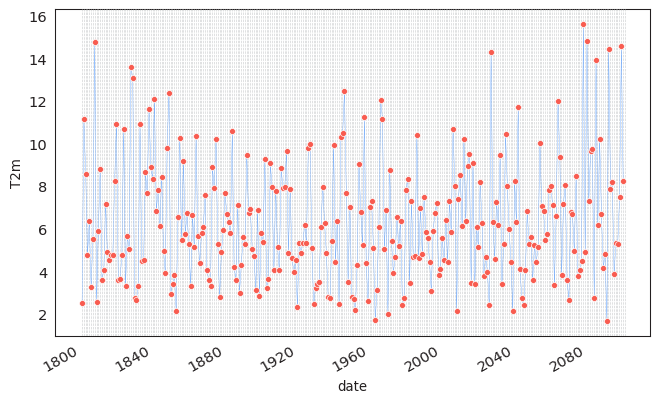

In [ ]:
# # take annual maxima
# extremes = model.get_extremes(method="BM", block_size="365D")
extremes = model.set_extremes(extremes=series)
model.plot_extremes()

/glade/u/apps/opt/conda/envs/npl/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


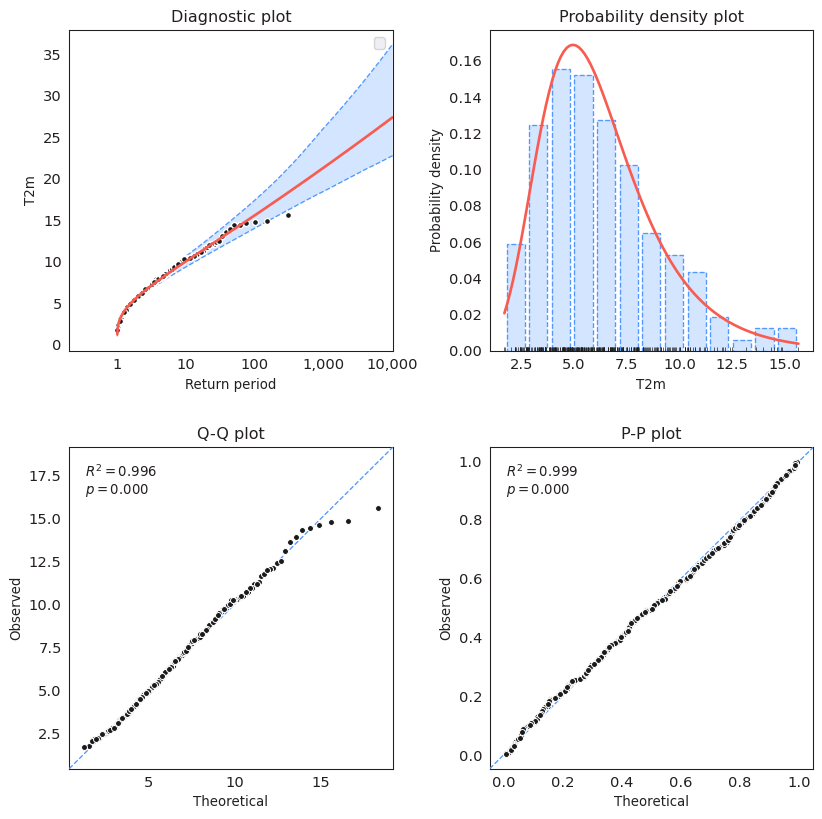

In [ ]:
# fit model using generalized extreme value distribution
model.fit_model(distribution="genextreme")
fig, axs = model.plot_diagnostic(alpha=0.95, figsize=(10, 10), return_period=np.logspace(-1, 4, 1000))
axs[0].set_title("Diagnostic plot")
# plot a straight line at 319
# axs[0].axhline(y=319, color='r', linestyle='--')
axs[0].set_xlim(0.20, 10000)
# axs[0].scatter(return_periods, extreme_values_sorted, color='r', s=3, alpha=1, label="2000-years control run")
axs[0].legend()

In [ ]:
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                           T2m      Size:                                 300
Start:                      December 1800      End:                        December 2099
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                300      Extraction method:                     BM
Type:                                high      Block size:             365 days 00:00:00
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               